### Detection-of-Manipulated-and-Authentic-Images

### Dataset Summary: [Link](https://www.kaggle.com/datasets/shivamardeshna/real-and-fake-images-dataset-for-image-forensics)

The dataset is divided into three sets: training, testing, and validation. Each set contains 'real' and 'fake' images.

Here is a breakdown of the number of images in each category:

| Set        | Type | Count |
|------------|------|-------|
| Training   | Fake | 20001 |
| Training   | Real | 20001 |
| **Total Training** |      | **40002** |
|------------|------|-------|
| Validation | Fake | 6161  |
| Validation | Real | 6199  |
| **Total Validation**|      | **12360** |
|------------|------|-------|
| Testing    | Fake | 2623  |
| Testing    | Real | 2604  |
| **Total Testing**  |      | **5227**  |
|------------|------|-------|
| **Grand Total**    |      | **57589** |

## 2. Project Requirements

### 2.1 Data Preparation
* Choose a dataset containing both real and fake samples in the selected media type. ✅
* Split the dataset into training, validation, and testing sets. ✅

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

2025-11-29 11:54:26.918543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764417267.095741      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764417267.153468      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
os.chdir(r'/kaggle/input/real-and-fake-images-dataset-for-image-forensics/Data Set 1/Data Set 1')

* Perform necessary preprocessing steps (e.g., resizing, normalization, noise removal, feature extraction).

In [3]:
# Define image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Load train dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'validation',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 40002 files belonging to 2 classes.


I0000 00:00:1764417322.069768      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 12360 files belonging to 2 classes.
Found 5227 files belonging to 2 classes.


### 2.2 Model Design
* Build a neural network manually
* Clearly define the architecture:
    - Number of layers
    - Activation functions
    - Loss function
    - Optimization method
    - Hyperparameters (learning rate, batch size, epochs, etc.)

In [5]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Data Augmentation
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)

# Rescaling
x = tf.keras.layers.Rescaling(1./255)(x)

# Block 1
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Block 2
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Block 3
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Block 4
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)

# Flatten and Dense
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [7]:
epochs = 20
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20


E0000 00:00:1764417345.519753      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764417347.105636     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


2501/2501 ━━━━━━━━━━━━━━━━━━━━ 192s 74ms/step - accuracy: 0.6099 - loss: 0.7686 - val_accuracy: 0.6474 - val_loss: 0.6438 - learning_rate: 0.0010
Epoch 2/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 178s 71ms/step - accuracy: 0.7189 - loss: 0.5454 - val_accuracy: 0.8422 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 3/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 178s 71ms/step - accuracy: 0.8240 - loss: 0.3847 - val_accuracy: 0.8187 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 4/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 178s 71ms/step - accuracy: 0.8520 - loss: 0.3388 - val_accuracy: 0.8563 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 5/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 179s 71ms/step - accuracy: 0.8817 - loss: 0.2775 - val_accuracy: 0.8662 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 6/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 178s 71ms/step - accuracy: 0.8882 - loss: 0.2679 - val_accuracy: 0.8792 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 7/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 178s 71ms/step - accuracy: 

In [8]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7328 - loss: 0.6877
Test Loss: 0.7961495518684387
Test Accuracy: 0.7417256832122803


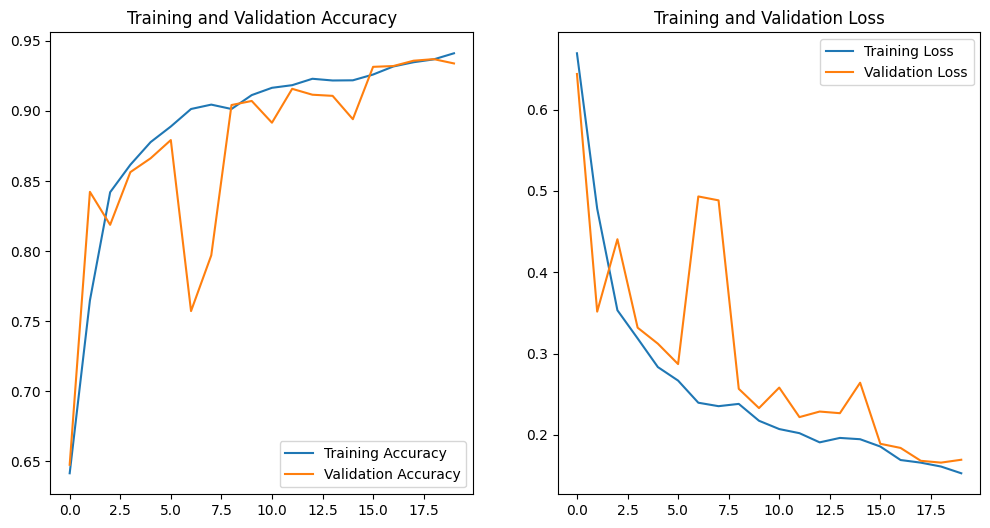

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2.3 Training and Evaluation
* Train the model using the prepared dataset.
* Validate the model during training to avoid overfitting.
* Evaluate final performance using metrics such as:
    - Accuracy
    - Precision / Recall / F1-Score
    - Confusion Matrix
* Provide a discussion of the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

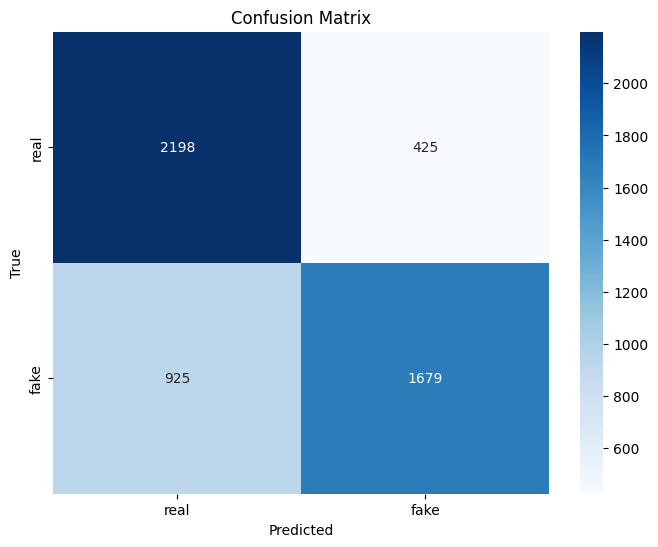

In [10]:
# Get predictions
y_pred = []
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images).flatten().round()) # Use extend for lists

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['real', 'fake']))

print('Confusion Matrix:')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 3. Deliverables

## 3.1 Source Code
* Complete and clean implementation
* Proper comments and modular structure
* Separate training, testing, and preprocessing scripts if possible
## 3.2 Presentation
* 5–8 minute presentation summarizing the project
* Slides should highlight the methodology, model structure, and results